# Алгоритм имитации отжига

Алгоритм имитации отжига - стохастический алгоритм оптимизации целевой функции, один из примеров методов Монте-Карло. Основан на имитации физического процесса, который происходит при отжиге металлов. 

Основная мысль алгоритма заключается в том, что при некотором изменении состоянии системы оценивается ее энергия (та самая минимизируемая функций), и если энергия нового состояния меньше, чем старого - то совершается переход, если нет - переход совершается с вероятностью $P(\Delta E) = e^{-\Delta E / t_i}$, где $t_i$ - температура системы в текущий момент, $\Delta E$ - разница энергий системы.

В отличие от генетических алгоритмов или градиентного спуска, данный алгоритм менее подвержен застреванию в локальных минимумах за счет стохастической природы (верно только для начальной фазы алгоритма, к концу вероятность выйти из них слишком мала).

В качестве примера возьмем ту же задачу, что и в ноутбуке по MCMC - нахождение параметров бета-распределения.

In [1]:
# импортируем все нужное
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from numba import jit

from scipy.stats import norm, beta

sns.set_style('white')
sns.set_context('talk')

np.random.seed(112)

In [2]:
# получаем случайные значения параметров для бета распределения (они обязательно положительны)
dist = sp.stats.uniform(0.1, 10)
beta_a, beta_b = dist.rvs(), dist.rvs()
print(beta_a, beta_b)

3.8505712887328514 6.503046199226442


Задаем само распределение с нашими параметрами и получаем данные из него.

In [3]:
beta_dist = sp.stats.beta(beta_a, beta_b)
data = beta_dist.rvs(size=200)

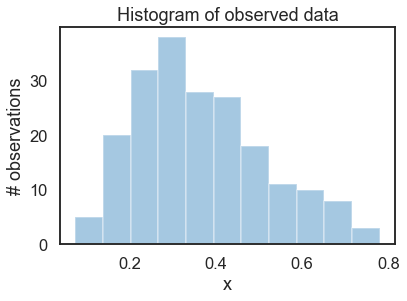

In [4]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Для начала нам нужна функция оценки "энергии" системы (меньше - лучше)

In [5]:
def energy(a, b):
    # будем использовать 1 / likelihood.sum() (не совсем верно, т.к. надо бы prod(),
    # но корректно с точки зрения функции энергии и избавляет нас от 100+ степеней)
    # чем более подходят параметры, тем меньше значение функции
    return 1000 / beta(a, b).pdf(data).sum()

Далее определим функцию, которая меняет параметр неким образом (будем брать его из стандартного нормального распределения)

In [6]:
@jit(nopython=True)
def change(param):
    # мы знаем, что параметры ограничены на (0.1, 10)
    param = np.random.normal(param, 2)
    if param < 0.1 or param > 10: param = np.random.uniform(0.1, 10)
    return param

Выберем один из методов снижения температуры - схему Больцмана.

In [7]:
def temp_change_f(starting_temp):
    @jit(nopython=True)
    def tchange(step): return starting_temp / np.log(2 + step)
    return tchange

Далее определим функцию перехода состояний

In [8]:
@jit(nopython=True)
def transition(deltaE, temperature):
    # возвращаем True (переход) если энергия уменьшилась
    # если энергия увеличилась, возвращаем True с некоторой вероятностью, зависящей от текущей температуры
    return True if deltaE <= 0 else np.random.rand() < 1 / (1 + np.exp(deltaE / temperature))

Определим начальную температуру и функцию снижения температуры

In [9]:
T_start = 10
temp_change = temp_change_f(T_start)

Запускаем алгоритм

In [10]:
current_a, current_b = np.random.rand() * 10, np.random.rand() * 10
current_temp = T_start
current_E = energy(current_a, current_b)
steps = 30000

for i in tqdm(range(steps)):
    next_a = change(current_a)
    delta_E = energy(next_a, current_b) - energy(current_a, current_b)
    if transition(delta_E, current_temp):
        current_a = next_a
    
    next_b = change(current_b)
    delta_E = energy(current_a, next_b) - energy(current_a, current_b)
    if transition(delta_E, current_temp):
        current_b = next_b
    current_temp = temp_change(i)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:23<00:00, 208.85it/s]


In [11]:
print(f"Calculated a = {current_a}, calculated b = {current_b}")
print(f"True a = {beta_a}, true b = {beta_b}")
print(f"Energy difference: {energy(current_a, current_b) - energy(beta_a, beta_b)}")

Calculated a = 1.272623224535523, calculated b = 3.4941060269739177
True a = 3.8505712887328514, true b = 6.503046199226442
Energy difference: 0.9506144674498076


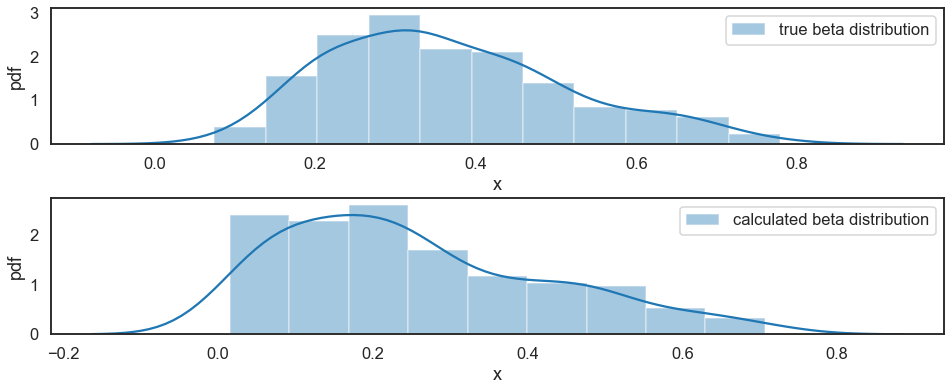

In [12]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(211)
bx = fig.add_subplot(212)

sns.distplot(data, ax=ax, label='true beta distribution')
x = np.linspace(0, 10, 500)
_ = ax.set(xlabel='x', ylabel='pdf');
ax.legend();

sns.distplot(np.random.beta(current_a, current_b, size=200), ax=bx, label='calculated beta distribution')
x = np.linspace(0, 10, 500)
_ = bx.set(xlabel='x', ylabel='pdf');
bx.legend();